# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Data-Generating-Process" data-toc-modified-id="Data-Generating-Process-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Generating Process</a></div><div class="lev1 toc-item"><a href="#Variational-Bayes" data-toc-modified-id="Variational-Bayes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Variational Bayes</a></div>

In [1]:
%matplotlib inline

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.misc import logsumexp
from scipy.special import psi

# Data Generating Process

`np.squeeze(np.asarray( ))`が多用されているのは、numpyでも(無理やり)縦ベクトルを基準としていて、関数に通すときにエラーが出るため

In [107]:
D = 2 # Data dimension
K = 4 # numbrt of mixture components
N = 3500 # number of observation

alpha = 100 * np.mat(np.ones(K)[:, np.newaxis])
a = 1.0 *  np.ones(D)
b = 100

pi = np.mat(np.random.dirichlet(np.squeeze(np.asarray(alpha)))[:, np.newaxis])
lambda_ = np.mat([np.random.gamma(a, b) for i in range(K)])
z = np.mat(np.array([np.random.multinomial(1, np.squeeze(np.asarray(pi)), size=1) for i in range(N)])).T

data = np.mat(np.zeros((D, N)))
for i in range(N):
    lambda_d = lambda_.T * z[:,i]
    data[:, i] = np.mat(np.random.poisson(lam=np.squeeze(np.asarray(lambda_.T * z[:,i])), size=(1,2))).T

colorlist = ["r", "g", "b", "y", "c", "k", "m", "w"]
z_cat = []
for i in range(N):
    for k in range(K):
        if int(z[k, i]) == 1:
            z_cat.append(colorlist[k])

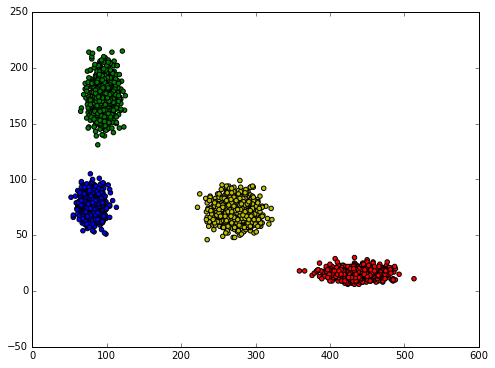

In [108]:
data_x = [] ; data_y = []
for i in range(N):
    data_x.append(data[0, i])
    data_y.append(data[1, i])

plt.rcParams['figure.figsize'] = (8, 6)
plt.scatter(data_x, data_y, c=z_cat)

# Variational Bayes

In [74]:
def update_pi(alpha, Z, K):
    alpha_tmp = np.mat(np.zeros(K)[:, np.newaxis])
    
    for k in range(K):
        alpha_tmp[k, 0] = alpha[k, 0] + Z[k, :].sum()

    alpha_tmp = alpha_tmp / alpha_tmp.sum()
    pi = np.mat(np.random.dirichlet(np.squeeze(np.asarray(alpha_tmp)))[:, np.newaxis])

    return pi, alpha_tmp

In [75]:
def update_lambda(a, b, data, Z, D):
    gamma_param = []
    for k in range(K):
        a_new = a + np.array([(data * Z.T)[d, k] for d in range(D)])
        b_new = b + Z[k, :].sum()
        gamma_param.append([a_new, b_new])
        
    return gamma_param

In [76]:
def update_z(data, K, pi, alpha, gamma_param):
    D, N = data.shape
    Z_expt = np.mat(np.zeros((K, N)))
    expsum_temp = np.mat(np.zeros((K, N)))
    tmp = np.zeros(K)

    sum_digamma_tmp = psi(alpha.sum())
    for k in range(K):
        tmp[k] = - (gamma_param[k][0].sum() / gamma_param[k][1])
        tmp[k] += psi(alpha[k][0,0]) - sum_digamma_tmp

    ln_lambda_X = [data.T * (psi(np.mat(gamma_param[k][0]).T) - np.log(gamma_param[k][1])) for k in range(K)]

    for n in range(N):
        tmp_ln_pi =  [(tmp[k] + ln_lambda_X[k][n])[0,0] for k in range(K)]
        Z_expt[:, n] = np.mat(np.exp(tmp_ln_pi - logsumexp(tmp_ln_pi))).T

    return Z_expt

In [109]:
# initialization
D, N = data.shape
K = 8
alpha = 100 * np.mat(np.ones(K)[:, np.newaxis])
Z  = np.mat(np.array([np.random.multinomial(1, np.ones(K)/K, size=1) for i in range(N)])).T
lambda_ = np.mat([np.random.gamma(a, b)for i in range(K)])
pi, alpha = update_pi(alpha, Z, K)
gamma_param = update_lambda(a, b, data, Z, D)

# inference
for i in range(90):
    # E-Step
    Z_expt = update_z(data, K, pi, alpha, gamma_param)
    
    # M-Step
    pi, alpha = update_pi(alpha, Z_expt, K)
    gamma_param = update_lambda(a, b, data, Z_expt, D)

In [110]:
infered_cat = [np.argmax(np.squeeze(np.asarray(Z_expt[:, i]))) for i in range(N)]

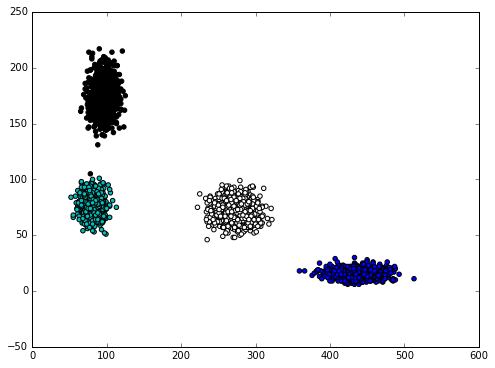

In [111]:
colorlist = ["r", "g", "b", "y", "c", "k", "m", "w"]
infered_cat_color = [colorlist[k] for k in infered_cat]

data_x = [] ; data_y = []
for i in range(N):
    data_x.append(data[0, i])
    data_y.append(data[1, i])

plt.rcParams['figure.figsize'] = (8, 6)
plt.scatter(data_x, data_y, c=infered_cat_color)

* データ数が十分あれば大丈夫だった